In [1]:
#!pip install nltk

In [2]:
# Run in python console

#nltk.download('stopwords')

In [3]:
# Run in terminal or command prompt
#!python -m spacy download en_core_web_sm

In [4]:
#!pip install pyLDAvis

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk;
from pandasql import sqldf
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from my_funcs import get_df_keywords

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
import ast

def get_from_textlist(df):
    data_lemmatized = []
    print("--DATA_LEMMATIZED--")
    if 'text_list' in df.columns:
        list_data_lemmatized = df["text_list"].tolist()
        for lista in tqdm(list_data_lemmatized):
            data_lemmatized.append(ast.literal_eval(lista)
        )
    else:
        print('text_list not found')
        return
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    return corpus, id2word, data_lemmatized

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    print("--LDA_MODELS--")
    for num_topics in tqdm(range(start, limit, step)):
        
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
def format_topics_documents(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(tqdm(ldamodel[corpus])):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate((row)):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# requiere los archivos que estan en la carpeta dominant topic (subien2)

In [9]:
# 0, 13
ORIGINAL_TOPIC = 0
# (13,0)

filename = f'./dominant_topics/dominant_topic{ORIGINAL_TOPIC}.csv'
df = pd.read_csv(filename)
corpus, id2word, data_lemmatized = get_from_textlist(df)
# Can take a long time to run.
limit=10; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start, limit=limit, step=1)

--DATA_LEMMATIZED--


100%|███████████████████████████████████████| 141/141 [00:00<00:00, 2764.35it/s]


--LDA_MODELS--


100%|█████████████████████████████████████████████| 8/8 [00:14<00:00,  1.80s/it]


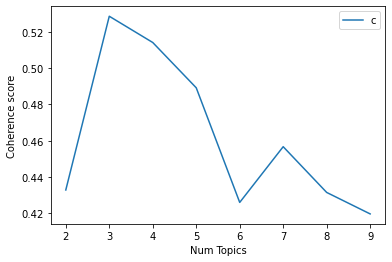

In [10]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [11]:
# Print the coherence scores
for i, (m, cv) in enumerate(zip(x, coherence_values)):
    print(f" [{i}] Num Topics = {m}  has Coherence Value of {cv:.4f}")

 [0] Num Topics = 2  has Coherence Value of 0.4329
 [1] Num Topics = 3  has Coherence Value of 0.5285
 [2] Num Topics = 4  has Coherence Value of 0.5140
 [3] Num Topics = 5  has Coherence Value of 0.4891
 [4] Num Topics = 6  has Coherence Value of 0.4260
 [5] Num Topics = 7  has Coherence Value of 0.4567
 [6] Num Topics = 8  has Coherence Value of 0.4315
 [7] Num Topics = 9  has Coherence Value of 0.4197


In [12]:
# elegir
idx_optimo = 2
optimal_model = model_list[idx_optimo]
optimal_ntopics = len(model_list[idx_optimo].get_topics())

In [13]:
df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model,
                                                  corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_list']
df_dominant_topic.head(10)

100%|████████████████████████████████████████| 141/141 [00:00<00:00, 142.72it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,1.0,0.5009,"derecho, agua, territorio, derechos_humano, ta...","[organización, social, accederar, beneficio, a..."
1,1,0.0,0.7292,"agua, proceso, proyecto, nuevo, derecho, candi...","[grave, derechos, agua, hidroelectrico, aysen,..."
2,2,3.0,0.7189,"nacional, especie, ave, humedal, proteger, san...","[comunidad, indigén, pedir, moncul, acusar, de..."
3,3,1.0,0.8884,"derecho, agua, territorio, derechos_humano, ta...","[opinar, pueblos_originario, iniciar, proceso,..."
4,4,4.0,0.9559,"tierra, asteroid, asteroide, muestra, kilometr...","[asteroide, potencialmente_peligroso, acercar,..."
5,5,5.0,0.9969,"pueblo, escanos_reservado, indigén, pueblos_or...","[organización, rechazar, negociacion, senado, ..."
6,6,2.0,0.9962,"nuevo, persona, tratar, ley, tierra, acuerdo, ...","[supuesto, propietario, acudir, justicia, trab..."
7,7,4.0,0.8906,"tierra, asteroid, asteroide, muestra, kilometr...","[nás, historico, agencia_espacial, tardarar, s..."
8,8,3.0,0.4797,"nacional, especie, ave, humedal, proteger, san...","[impresionante, imagen, presentar, nás, cambio..."
9,9,1.0,0.5752,"derecho, agua, territorio, derechos_humano, ta...","[fuerza, cultural, paso, partido, formacion, m..."


In [14]:
#ver los keywords de cada topico
get_df_keywords(optimal_model, optimal_ntopics)

,0,1,2,3,4,5
0,agua,derecho,nuevo,nacional,tierra,pueblo
1,proceso,agua,persona,especie,asteroid,escanos_reservado
2,proyecto,territorio,tratar,ave,asteroide,indigén
3,nuevo,derechos_humano,ley,humedal,muestra,pueblos_originario
4,derecho,tambien,tierra,proteger,kilometro,indigena
5,candidato,mapuche,acuerdo,santuario,planeta,organización
6,organización,pueblo,derecho,ambiental,nás,comunidad
7,animal,indigena,territorio,glaciar,metro,proceso
8,constituyente,proteccion,nacional,medio_ambiente,cientifico,grupo
9,escanos,ambiental,agua,proyecto,paso,participacion


In [15]:
pd.set_option('display.max_colwidth', 210)

In [16]:
df[df_dominant_topic['Dominant_Topic'] == 0][['id', 'content']]
#_df = df[df_dominant_topic['Dominant_Topic'] == 0]

,id,content
1,5165457,"Grave: Derechos de agua de hidroeléctrica en Aysén está bloqueando suministro a pobladores de Puerto Guadal. Una de las explicaciones del origen del nombre de Puerto Guadal es que vendría de “aguadal”, luga..."
10,4049038,Más de 20 activistas envían carta al Presidente Piñera exigiendo que suscriba el Acuerdo de Escazú tras negativa del Gobierno. Luego de que el canciller Andrés Allamand anunciara que el Gobierno no firmará ...
12,5148316,"Valparaíso: Ministerio de Medio Ambiente retiró solicitud que declaraba dos nuevos Santuarios de la Naturaleza. El humedal Salinas ubicado en la localidad de Pullally de la comuna de Papudo, y las dunas de ..."
20,62050,Los Ríos: Confirman que vecinos y organizaciones administrarán futuro Santuario Angachilla. El Ministerio de Medio Ambiente confirmó que serán vecinos y organizaciones sociales los que administrarán el futu...
21,3921221,Aprueban 17 escaños reservados para pueblos originarios en Convención Constitucional. La Comisión Mixta del Congreso finalmente aprobó 17 escaños reservados para los pueblos originarios en la Convención Con...
23,13410789,A un día del cierre de inscripciones: Un pueblo originario no tiene candidatos y tres no logran patrocinios para Convención. Este lunes 11 de enero a las 23:59 horas vence el plazo de declaración de candida...
24,5160083,"Petorca: Agrupaciones rurales piden derogar el Código de Aguas. En entrevista con Radio Cooperativa, las agrupaciones del agua potable rural de Petorca, llamaron a derogar el Código de Aguas y limitar la pr..."
25,13413848,"Más discriminados por su nacionalidad que por su orientación: Las cifras de la 1° encuesta a los migrantes LGBTIQ+ en Chile. Infografía: Johanna Mellado, Emol | Contenido: José Manuel Vilche..."
47,7352946,"Comenzó un nuevo ciclo solar: NASA explica los eventuales riesgos que existen para la Tierra. El Sol inició un nuevo ciclo en diciembre del año pasado, el cual se prolonga por 11 años y se espera que tenga ..."
48,5162434,"Valle del Huasco: SEA de Atacama dio por desistido proyecto de sondaje de minera Nueva Unión SpA. Este lunes 5 de octubre, el SEA de Atacama dio por desistido el proyecto “Sondajes Minero La Fortuna”, de la..."


In [17]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,1.0,0.5009,"derecho, agua, territorio, derechos_humano, tambien, mapuche, pueblo, indigena, proteccion, ambiental","[organización, social, accederar, beneficio, asociacion_chilén, farmacias_popular, organización, social, gremial, junto, vecino, común, firmar, jueves, octubre, convenio, asociacion_chilén, farmacias_popula..."
1,1,0.0,0.7292,"agua, proceso, proyecto, nuevo, derecho, candidato, organización, animal, constituyente, escanos","[grave, derechos, agua, hidroelectrico, aysen, bloquear, suministro, poblador, puerto, explicación, origen, nombre, puerto, lugar, mallinoso, agua, fluir, doquier, emplazamiento, orilla, general, carrero, r..."
2,2,3.0,0.7189,"nacional, especie, ave, humedal, proteger, santuario, ambiental, glaciar, medio_ambiente, proyecto","[comunidad, indigén, pedir, moncul, acusar, destruccion, motociclista, comunidad, indigén, acuso, motociclista, destruir, humedal, moncul, sitio, ecologico, encontrar, protegido, convencion, internacional, ..."
3,3,1.0,0.8884,"derecho, agua, territorio, derechos_humano, tambien, mapuche, pueblo, indigena, proteccion, ambiental","[opinar, pueblos_originario, iniciar, proceso, partipacion, intercutural, censo, parte, preparativo, proximo, censo, instituto, nacional, comenzo, hoy, proceso, participacion, intercultural, primero, etapa,..."
4,4,4.0,0.9559,"tierra, asteroid, asteroide, muestra, kilometro, planeta, nás, metro, cientifico, paso","[asteroide, potencialmente_peligroso, acercar, tierra, domingo, domingo, noviembre, distanciar, relativamente, cercano, tierra, aproximar, asteroide, considerado, potencialmente_peligroso, asi, calificado, ..."
...,...,...,...,...,...
136,136,4.0,0.9983,"tierra, asteroid, asteroide, muestra, kilometro, planeta, nás, metro, cientifico, paso","[asteroide, conocer, volvera, pasar, cerca, tierra, sabado, alrededor, mundo, celebrar, noche, bruja, fecha, nino, recorrer, barrio, pedir, dulce, vecino, atmosfera, festejo, misterio, alcanz, celebracion, ..."
137,137,3.0,0.9971,"nacional, especie, ave, humedal, proteger, santuario, ambiental, glaciar, medio_ambiente, proyecto","[demonio, regresar, continental, primero, vez, ano, marsupial, desaparecido, hacer, continental, reintroducido, recientemente, inmenso, isla, etapo, historico, ambicioso, programa, proteccion, especie, reve..."
138,138,0.0,0.5545,"agua, proceso, proyecto, nuevo, derecho, candidato, organización, animal, constituyente, escanos","[proponer, abogada, mapuche, constituyente, semana, comunidad, organización, mapuche, intercultural, territorio, zona, centro, sur, hecho, surgir, trav, redes_social, nombre, pilquimar, levantar, candidatur..."
139,139,5.0,0.9988,"pueblo, escanos_reservado, indigén, pueblos_originario, indigena, organización, comunidad, proceso, grupo, participacion","[demandar, tribunal, internacional, escanos_reservado, miercoles, noviembre, comunidades_asociación, presentar, demanda, derechos_humano, cidh, reclamar, consulta, mecanismo, escanos_reservado, segun, deman..."


In [18]:
# que topicos vale la pena considerar
df_dominant_topic['Dominant_Topic'].value_counts()

1.0    39
4.0    26
0.0    23
3.0    21
2.0    18
5.0    14
Name: Dominant_Topic, dtype: int64

In [19]:
topic = 2
df_dominant_topic[df_dominant_topic['Dominant_Topic'] == float(topic)][['Document_No', 'text_list']]

,Document_No,text_list
6,6,"[supuesto, propietario, acudir, justicia, trabar, polemico, venta, polemico, vento, ubicado, debido, supuesto, dueno, terreno, recurrio, justicia, trabar, venta, acuerdo, bio, tratar, vittorio, noli, plante..."
22,22,"[presidente, sebastian_pinera, escanos_reservado, pueblos_originario, reconocimientir, dignidad, identidad, pueblo, presidente, sebastian_pinera, promulgo, miercoles, nuevo, reforma, constitucional, garanti..."
28,28,"[duén, comunidad, mapuche, tomar, mapuche, region, araucanio, tratar, santa_lucia, chufcar, ubicado, sector, norte, loncochar, metro, centro, común, ocupado, tarde, huenumilla, integrante, comunidad, asegur..."
29,29,"[movimiento, agua, territorio, naturaleza, reconocer, sujeto, derecho, proximo, plebiscito, diversidad, caracterizar, movimiento, agua, territorio, declarar, frente, actual, proceso, constituyente, siguient..."
46,46,"[organización, pedir, aprobar, escano, convencion_constitucional, red, chileno, estudio, emitio, declaracion, debate, escano_reservado, pueblo, primero, diputado, luego, enfrentar, decisión, relevante, cara..."
57,57,"[contralorio, rechazar, intento, conadi, entregar, dinero, devolver, tierra, usurpada, comunidades_indigena, patricio, general, forma, negativo, consulta, nacional, intentar, eludir, responsabilidad, trabaj..."
60,60,"[urgente, clan, aeropuerto, rapa_nui, protesta, nulo, respuesta, historico, demandar, territorial, ciudadano, noche, lunes, noviembre, dependencia, aeropuerto, rapa_nui, cansado, nulo, respuesta, historico,..."
63,63,"[indh, realizar, observacion, conflicto_socioambiental, portuario, semana, funcionario, instituto, nacional, derechos_humano, indh, sede, valparaiso, realizar, visita, conflicto_socioambiental, ubicado, sec..."
69,69,"[comunidad, rapa_nui, rechazo, anuncio, gobierno, reclamar, anciano, rapa_nui, rechazo, intencion, traspasar, fisco, territorio_maritimo, aereo, indicar, manifestar, tomar, acceso, isla, alcalde, pedro_edmu..."
76,76,"[trar, polemico, venta, isla_guafo, supuesto, propietario, acudir, justicia, reclamar, insulo, decretado, solicito, supuesto, propietario, impedir, venta, supuesto, heredero, terreno, proponer, crear, reser..."


In [20]:
"""0 	1-Mundo 	8609
1 	7-Deporte 	6708
2 	4-Ciencias_y_Tecnología 	4225
3 	2-Economía 	2636
4 	3-Política_y_Conflictos 	1923
5 	10-Salud 	333
6 	6-Cultura_y_Artes 	185
7 	8-Ecología_y_Planeta 	135
8 	9-Crimen_delitos_y_Justicia 	130"""
cats_dict = {#1 : '8-Ecología_y_Planeta',
             #2 : '9-Crimen_delitos_y_Justicia',
             #3 : '3-Política_y_Conflictos',
             #0 : '10-Salud',
             1 : '2-Economía',
             2 : '1-Mundo',
            3: '4-Ciencias_y_Tecnología',
             4 : '8-Ecología_y_Planeta',}


for i in range(optimal_ntopics):
    if i not in cats_dict.keys():
        cats_dict[i] = np.nan
        
cats_dict

{1: '2-Economía',
 2: '1-Mundo',
 3: '4-Ciencias_y_Tecnología',
 4: '8-Ecología_y_Planeta',
 0: nan,
 5: nan}

In [ ]:
freno_de_emergencia()

In [ ]:
# combinar el df inicial con el que tiene los subptopicos
final_df = df.drop(columns=['Dominant_Topic', 'text_list'])
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
final_df = pd.concat([final_df, df_dominant_topic[['Dominant_Topic', 'Keywords', 'text_list']]], axis=1)
final_df['Dominant_Topic'] = final_df['Dominant_Topic'].astype(int)

In [ ]:
#verificamos (al ojo) que el contenido coincida con text_list
final_df[['id', 'content', 'Dominant_Topic', 'text_list']]

In [ ]:
#guardamos solo los subtopicos que determinamos que tienen una categoria equivalente
final_df['category'] = final_df.apply(lambda row : cats_dict[row.Dominant_Topic], axis=1)
final_df = final_df[final_df['category'].notna()]
final_df.to_csv(f'./dominant_topics/topic{ORIGINAL_TOPIC}_revisado_cat.csv')
final_df[['content', 'category']]